In [1]:
!python --version
!pip install pandas

Python 3.7.7


In [1]:
#https://stackoverflow.com/questions/53457975/pyspark-udf-function-error-in-lambda-function
import os

os.environ['OBJC_DISABLE_INITIALIZE_FORK_SAFETY'] = 'YES'

In [2]:
from pyspark.sql import SparkSession
# https://spark.apache.org/docs/latest/job-scheduling.html
spark = SparkSession.\
        builder.\
        appName("pyspark-notebook2-dave").\
        master("spark://spark-master:7077").\
        config("spark.executor.memory", "7g").\
        config("spark.cores.max", "3").\
        config("spark.executor.instances", "1").\
        config("spark.executor.cores", "3").\
        config("spark.mongodb.input.uri","mongodb://mongo1:27017,mongo2:27018,mongo3:27019/database.horses_collection?replicaSet=rs0").\
        config("spark.mongodb.output.uri","mongodb://mongo1:27017,mongo2:27018,mongo3:27019/database.horses_collection?replicaSet=rs0").\
        config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12:3.0.0").\
        getOrCreate()

Ivy Default Cache set to: /home/jovyan/.ivy2/cache
The jars for the packages stored in: /home/jovyan/.ivy2/jars
:: loading settings :: url = jar:file:/usr/local/spark-3.0.0-bin-hadoop3.2/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml
org.mongodb.spark#mongo-spark-connector_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-ab8ff933-bba5-4831-9c3f-8dd628135a59;1.0
	confs: [default]
	found org.mongodb.spark#mongo-spark-connector_2.12;3.0.0 in central
	found org.mongodb#mongodb-driver-sync;4.0.5 in central
	found org.mongodb#bson;4.0.5 in central
	found org.mongodb#mongodb-driver-core;4.0.5 in central
:: resolution report :: resolve 876ms :: artifacts dl 37ms
	:: modules in use:
	org.mongodb#bson;4.0.5 from central in [default]
	org.mongodb#mongodb-driver-core;4.0.5 from central in [default]
	org.mongodb#mongodb-driver-sync;4.0.5 from central in [default]
	org.mongodb.spark#mongo-spark-connector_2.12;3.0.0 from central in [defaul

In [3]:
spark.catalog.currentDatabase()

'default'

In [4]:
# reading dataframes from MongoDB

# sampleSize - https://stackoverflow.com/a/56255303
df = spark.read.format("mongo").option('sampleSize', 50000).load()
df.createOrReplaceTempView("mongo")

21/12/21 21:48:24 WARN MongoInferSchema: Field 'bsp' contains conflicting types converting to StringType
21/12/21 21:48:27 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [5]:
df.printSchema()

root
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- clk: string (nullable = true)
 |-- mc: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- id: string (nullable = true)
 |    |    |-- marketDefinition: struct (nullable = true)
 |    |    |    |-- betDelay: integer (nullable = true)
 |    |    |    |-- bettingType: string (nullable = true)
 |    |    |    |-- bspMarket: boolean (nullable = true)
 |    |    |    |-- bspReconciled: boolean (nullable = true)
 |    |    |    |-- complete: boolean (nullable = true)
 |    |    |    |-- countryCode: string (nullable = true)
 |    |    |    |-- crossMatching: boolean (nullable = true)
 |    |    |    |-- discountAllowed: boolean (nullable = true)
 |    |    |    |-- eachWayDivisor: double (nullable = true)
 |    |    |    |-- eventId: string (nullable = true)
 |    |    |    |-- eventName: string (nullable = true)
 |    |    |    |-- eventTypeId: string (nullable = true)
 | 

In [6]:
df.show()

+--------------------+----------+--------------------+---+-------------+
|                 _id|       clk|                  mc| op|           pt|
+--------------------+----------+--------------------+---+-------------+
|[619e9dd8677066b2...|2480088678|[[1.124699287, [0...|mcm|1462537993283|
|[619e9dd8677066b2...|2480249142|[[1.124699287, [0...|mcm|1462540135101|
|[619e9dd8677066b2...|2481803835|[[1.124699287, [0...|mcm|1462555384075|
|[619e9dd8677066b2...|2481994285|[[1.124699287,, [...|mcm|1462557371191|
|[619e9dd8677066b2...|2482055516|[[1.124699287,, [...|mcm|1462557910955|
|[619e9dd8677066b2...|2482072939|[[1.124699287,, [...|mcm|1462558089056|
|[619e9dd8677066b2...|2482078964|[[1.124699287,, [...|mcm|1462558150717|
|[619e9dd8677066b2...|2482083965|[[1.124699287, [0...|mcm|1462558199155|
|[619e9dd8677066b2...|2482177634|[[1.124699287, [0...|mcm|1462559078531|
|[619e9dd8677066b2...|2480088678|[[1.124699285, [0...|mcm|1462537993283|
|[619e9dd8677066b2...|2480212422|[[1.124699285, [0.

In [7]:
# spark.sql("select * from mongo array_contains(root.mc, array('CLOSED'))").show()
from pyspark.sql.functions import *   # Explodes lists into rows.

In [8]:
mc_exploded = df.select('*', explode(df.mc).alias('mc_row'))

In [9]:
md_only = mc_exploded.filter(mc_exploded.mc_row.marketDefinition.isNotNull())

In [10]:
md_only.show()

+--------------------+----------+--------------------+---+-------------+--------------------+
|                 _id|       clk|                  mc| op|           pt|              mc_row|
+--------------------+----------+--------------------+---+-------------+--------------------+
|[619e9dd8677066b2...|2480088678|[[1.124699287, [0...|mcm|1462537993283|[1.124699287, [0,...|
|[619e9dd8677066b2...|2480249142|[[1.124699287, [0...|mcm|1462540135101|[1.124699287, [0,...|
|[619e9dd8677066b2...|2481803835|[[1.124699287, [0...|mcm|1462555384075|[1.124699287, [0,...|
|[619e9dd8677066b2...|2482083965|[[1.124699287, [0...|mcm|1462558199155|[1.124699287, [0,...|
|[619e9dd8677066b2...|2482177634|[[1.124699287, [0...|mcm|1462559078531|[1.124699287, [0,...|
|[619e9dd8677066b2...|2480088678|[[1.124699285, [0...|mcm|1462537993283|[1.124699285, [0,...|
|[619e9dd8677066b2...|2480212422|[[1.124699285, [0...|mcm|1462539800697|[1.124699285, [0,...|
|[619e9dd8677066b2...|2480409166|[[1.124699285, [0...|mcm|14

In [11]:
# Explode the marketDefinition array.
market_definitions = md_only.selectExpr('op AS operation_type',
                                        'clk AS sequence_token',
                                        'pt AS published_time',
                                        'mc_row.id AS market_id',
                                        'mc_row.rc AS rc',
                                        'mc_row.marketDefinition.betDelay AS bet_delay',
                                        'mc_row.marketDefinition.bettingType AS betting_type',
                                        'mc_row.marketDefinition.bspMarket AS bsp_market',
                                        'mc_row.marketDefinition.bspReconciled AS bsp_reconciled',
                                        'mc_row.marketDefinition.complete AS complete',
                                        'mc_row.marketDefinition.countryCode AS country_code',
                                        'mc_row.marketDefinition.crossMatching AS cross_matching',
                                        'mc_row.marketDefinition.discountAllowed AS discount_allowed',
                                        'mc_row.marketDefinition.eventId AS event_id',
                                        'mc_row.marketDefinition.eventName AS event_name',
                                        'mc_row.marketDefinition.eventTypeId AS event_type_id',
                                        'mc_row.marketDefinition.inPlay AS in_play',
                                        'mc_row.marketDefinition.marketBaseRate AS market_base_rate',
                                        'mc_row.marketDefinition.marketTime AS market_time',
                                        'mc_row.marketDefinition.marketType AS market_type',
                                        'mc_row.marketDefinition.numberOfActiveRunners AS number_of_active_runners',
                                        'mc_row.marketDefinition.numberOfWinners AS number_of_winners',
                                        'mc_row.marketDefinition.openDate AS open_date',
                                        'mc_row.marketDefinition.persistenceEnabled AS persistence_enabled',
                                        'mc_row.marketDefinition.runnersVoidable AS runners_voidable',
                                        'mc_row.marketDefinition.settledTime AS settled_time',
                                        'mc_row.marketDefinition.status AS status',
                                        'mc_row.marketDefinition.suspendTime AS suspend_time',
                                        'mc_row.marketDefinition.timezone AS timezone',
                                        'mc_row.marketDefinition.turnInPlayEnabled AS turn_in_play_enabled',
                                        'mc_row.marketDefinition.version AS version',
                                        'mc_row.marketDefinition.name AS market_name',
                                        'mc_row.marketDefinition.regulators AS regulators',
                                        'mc_row.marketDefinition.runners AS runners')

In [12]:
market_definitions1 = market_definitions.filter(market_definitions["status"]=="CLOSED")

In [13]:
market_definitions1 = market_definitions1.filter(market_definitions["market_type"]=="WIN")

In [14]:
runners_only = market_definitions1.filter(market_definitions.runners.isNotNull())

In [15]:
# Explode the Runners array.
runners_exploded = runners_only.select(market_definitions1.operation_type,
                                       market_definitions1.published_time,
                                       market_definitions1.market_id,
                                       market_definitions1.market_name,
                                       market_definitions1.event_id,
                                       market_definitions1.event_name,
                                       explode(market_definitions1.runners).alias('runner_row'))

In [16]:
##### new dataset (just added BSP to the runners dataframe created above)
runners_exploded_wbsp = runners_only.select(market_definitions1.operation_type,
                                       market_definitions1.published_time,
                                       market_definitions1.market_id,
                                       market_definitions1.market_name,
                                       market_definitions1.event_id,
                                       market_definitions1.event_name,
                                       explode(market_definitions1.runners).alias('runner_row'))

In [17]:
##### new dataset (just added BSP to the runners dataframe created above)
runners_wbsp = runners_exploded_wbsp.selectExpr('operation_type',
                                      'published_time',
                                      'market_id',
                                      'market_name',
                                      'event_id',
                                      'event_name',
                                      'runner_row.id AS runner_id',
                                      'runner_row.name AS runner_name',
                                      'runner_row.status AS runner_status',
                                      'runner_row.bsp AS bsp',
                                      'runner_row.sortPriority AS runner_sort_priority')

In [18]:
##### new dataset (just added BSP to the runners dataframe created above)
runners_wbsp = runners_wbsp.filter(runners_wbsp.runner_status!='REMOVED')

In [19]:
runners_wbsp = runners_wbsp.filter(runners_wbsp.runner_status!='REMOVED_VACANT')

In [20]:
runners_wbsp = runners_wbsp.filter(runners_wbsp.bsp!='None')

In [21]:
runners_wbsp = runners_wbsp.filter(runners_wbsp.bsp!='NaN')

In [22]:
##### new dataset (just added BSP to the runners dataframe created above)
runners_wbsp.show()

+--------------+--------------+-----------+---------------+--------+-------------------+---------+------------------+-------------+------+--------------------+
|operation_type|published_time|  market_id|    market_name|event_id|         event_name|runner_id|       runner_name|runner_status|   bsp|runner_sort_priority|
+--------------+--------------+-----------+---------------+--------+-------------------+---------+------------------+-------------+------+--------------------+
|           mcm| 1462501034557|1.124659130|     R8 1m Allw|27784588|EvangD (US) 5th May| 10575249|       Bitsys Half|        LOSER|  13.5|                   5|
|           mcm| 1462501034557|1.124659130|     R8 1m Allw|27784588|EvangD (US) 5th May| 10288198|         Blue Code|        LOSER|  32.0|                   6|
|           mcm| 1462501034557|1.124659130|     R8 1m Allw|27784588|EvangD (US) 5th May| 10116126|            Zartan|        LOSER| 57.95|                   7|
|           mcm| 1462501034557|1.1246591

In [23]:
# drop duplicates
runners_wbsp = runners_wbsp.dropDuplicates(['event_name', 'runner_name'])

In [24]:
# bsp is returns if you bet €1
# creating returns column that is bsp if the horse is a winner, otherwise -1
runners_returns = runners_wbsp \
        .withColumn("winnings", when(col("runner_status") == "WINNER", col("bsp") * 1).otherwise(-1)) \
        .withColumn("wins", when(col("runner_status") == "WINNER", 1).otherwise(0)) \
        .withColumn("losses", when(col("runner_status") == "LOSER", 1).otherwise(0)) 

In [25]:
runners_returns.show()

+--------------+--------------+-----------+---------------+--------+-------------------+---------+--------------------+-------------+------+--------------------+--------+----+------+
|operation_type|published_time|  market_id|    market_name|event_id|         event_name|runner_id|         runner_name|runner_status|   bsp|runner_sort_priority|winnings|wins|losses|
+--------------+--------------+-----------+---------------+--------+-------------------+---------+--------------------+-------------+------+--------------------+--------+----+------+
|           mcm| 1481366724731|1.128705455|R8 1660m Pace M|28045706|APrk (AUS) 10th Dec|  8295474|        3. Calcavado|        LOSER|169.55|                   4|    -1.0|   0|     1|
|           mcm| 1476522926521|1.127620359|R5 2138m Pace M|27974013|APrk (AUS) 15th Oct|  7584233|  10. Ima Morven Lad|       WINNER| 22.95|                  10|   22.95|   1|     0|
|           mcm| 1481882834875|1.128780179|R5 1660m Pace M|28051397|APrk (AUS) 16th D

In [26]:
import pyspark.sql.functions as F

runners_returns = runners_returns.withColumn('runner_name', F.split(F.col('runner_name'), '.'))

In [28]:
runners_returns.show()

+--------------+--------------+-----------+---------------+--------+-------------------+---------+--------------------+-------------+------+--------------------+--------+----+------+
|operation_type|published_time|  market_id|    market_name|event_id|         event_name|runner_id|         runner_name|runner_status|   bsp|runner_sort_priority|winnings|wins|losses|
+--------------+--------------+-----------+---------------+--------+-------------------+---------+--------------------+-------------+------+--------------------+--------+----+------+
|           mcm| 1481366724731|1.128705455|R8 1660m Pace M|28045706|APrk (AUS) 10th Dec|  8295474|[, , , , , , , , ...|        LOSER|169.55|                   4|    -1.0|   0|     1|
|           mcm| 1476522926521|1.127620359|R5 2138m Pace M|27974013|APrk (AUS) 15th Oct|  7584233|[, , , , , , , , ...|       WINNER| 22.95|                  10|   22.95|   1|     0|
|           mcm| 1481882834875|1.128780179|R5 1660m Pace M|28051397|APrk (AUS) 16th D

In [29]:
import pandas

In [30]:
# groupby runner name
# sum euro returns, win, losses
runners_returns_agg = runners_returns \
        .groupBy("runner_name") \
        .agg(sum("winnings"), 
             sum("wins").alias("total_wins"), 
             sum("losses").alias("total_losses"))

In [31]:
# add total races column
runners_returns_agg = runners_returns_agg \
        .withColumn("total_races", col("total_wins") + col("total_losses"))

In [32]:
# could load this dataframe to mqsql
runners_returns_agg.show()

+--------------------+-------------------+----------+------------+-----------+
|         runner_name|      sum(winnings)|total_wins|total_losses|total_races|
+--------------------+-------------------+----------+------------+-----------+
|[, , , , , , , , ...|              -6.11|         4|          20|         24|
|      [, , , , , , ]|  3044.720000000001|      1456|       10061|      11517|
|              [, , ]|-0.7799999999999994|         6|          20|         26|
|[, , , , , , , , ...|  2280.149999999999|       662|        5363|       6025|
|[, , , , , , , , ...|           Infinity|      5412|       42793|      48205|
|    [, , , , , , , ]| 1173.9200000000003|      1941|       14739|      16680|
|          [, , , , ]| 159.08999999999997|       239|        1784|       2023|
|[, , , , , , , , ...|-237.46999999999994|        44|         565|        609|
|[, , , , , , , , ...| 3223.3599999999988|      2276|       18106|      20382|
|        [, , , , , ]|  553.2099999999998|       680

In [ ]:
# replace inf values in euro_returns col, also rename the column to winnings - before loading to pandas


In [ ]:
# sort spark df here - before loading to pandas


In [30]:
runners_returns_agg_pandas = runners_returns_agg.toPandas()

In [31]:
runners_returns_agg_pandas.head()

,runner_name,euro_returns,total_wins,total_losses,total_races
0,Unrepented,54.40,4,10,14
1,Switched On,-3.96,1,16,17
2,Discreet Charm,-4.00,0,4,4
3,Superyacht,-2.00,0,2,2
4,One Away,23.00,1,11,12


In [32]:
runners_returns_agg_pandas.tail()

,runner_name,euro_returns,total_wins,total_losses,total_races
158110,2. Naturaliste,-1.0,0,1,1
158111,Captain Sedgwick,-1.0,0,1,1
158112,1. Cash Count,-1.0,0,1,1
158113,5. Bordeaux Bandit,-1.0,0,1,1
158114,3. Bassey,-1.0,0,1,1


In [33]:
# sort descending by euro returns
runners_returns_agg_pandas.sort_values(by=['winnings'] , ascending=False)

,runner_name,euro_returns,total_wins,total_losses,total_races
85328,Charlie Bear,inf,3,6,9
73941,Miss Victoria,inf,2,8,10
839,Capture The Drama,1014.19,4,6,10
26384,Docs Deal,981.55,4,7,11
108564,Our Cullenscrown N,966.00,1,4,5
...,...,...,...,...,...
8165,Grams And Ounces,-22.00,0,22,22
70508,Last Summer,-22.00,0,22,22
81410,Noble Asset,-24.00,0,24,24
40355,Rasberry Lips,-27.00,0,27,27


In [34]:
import numpy as np

In [35]:
# runners_returns_agg_pandas.replace([np.inf, -np.inf], np.nan, inplace=True)

In [36]:
runners_returns_agg_pandas.dropna(inplace=True)

In [37]:
# sort descending by euro returns
runners_returns_agg_pandas.sort_values(by=['winnings'] , ascending=False)

,runner_name,euro_returns,total_wins,total_losses,total_races
839,Capture The Drama,1014.19,4,6,10
26384,Docs Deal,981.55,4,7,11
108564,Our Cullenscrown N,966.00,1,4,5
93921,Fantastic Rock,965.41,2,7,9
11039,14.Coisa Boa,964.08,1,0,1
...,...,...,...,...,...
8165,Grams And Ounces,-22.00,0,22,22
12714,Oor Jock,-22.00,0,22,22
81410,Noble Asset,-24.00,0,24,24
40355,Rasberry Lips,-27.00,0,27,27


In [38]:
runners_returns_agg_pandas.shape

(158113, 5)

In [39]:
top_10 = runners_returns_agg_pandas.nlargest(10, 'winnings')

In [40]:
bottom_10 = runners_returns_agg_pandas.nsmallest(10, 'winnings')

In [41]:
top_10

,runner_name,euro_returns,total_wins,total_losses,total_races
839,Capture The Drama,1014.19,4,6,10
26384,Docs Deal,981.55,4,7,11
108564,Our Cullenscrown N,966.00,1,4,5
93921,Fantastic Rock,965.41,2,7,9
11039,14.Coisa Boa,964.08,1,0,1
29370,Hope For Paddy,960.31,3,9,12
842,Built Lika,925.78,1,1,2
136244,Yippity Hanover,896.00,1,4,5
42691,Ride Away Shark,886.00,1,14,15
56380,Dandy Flame,756.99,1,7,8


In [42]:
bottom_10

,runner_name,euro_returns,total_wins,total_losses,total_races
151044,Simply Black,-29.0,0,29,29
40355,Rasberry Lips,-27.0,0,27,27
81410,Noble Asset,-24.0,0,24,24
8165,Grams And Ounces,-22.0,0,22,22
12714,Oor Jock,-22.0,0,22,22
37976,Paulus,-22.0,0,22,22
61652,Verbosity,-22.0,0,22,22
70508,Last Summer,-22.0,0,22,22
125627,Sennockian Star,-22.0,0,22,22
111338,Miss Motivation,-21.0,0,21,21


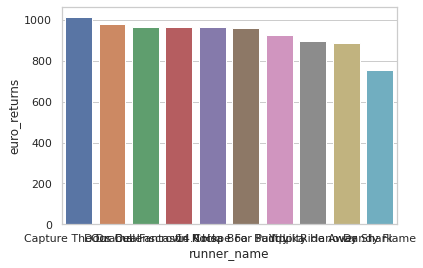

In [45]:
import seaborn as sns

sns.set_theme(style="whitegrid")
ax = sns.barplot(x="runner_name", y="winnings", data=top_10)

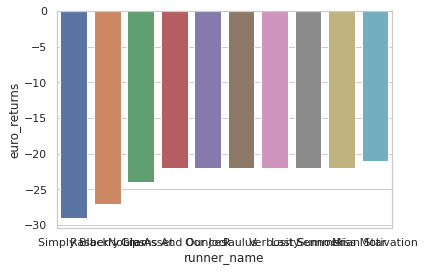

In [48]:
ax = sns.barplot(x="runner_name", y="winnings", data=bottom_10)

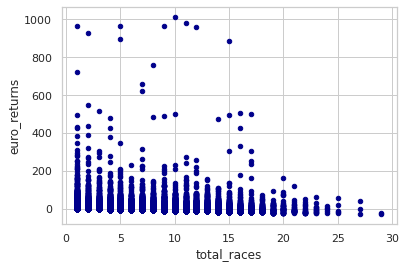

In [54]:
# plot winnings to total races scatterplot
ax1 = runners_returns_agg_pandas.plot.scatter(x='total_races',
                      y='euro_returns',
                      c='DarkBlue')


In [ ]:
###########################################################################################################

In [55]:
###########################################################################################################

In [56]:
# Select the useful fields, and give them user friendly names.
# runners = runners_exploded.selectExpr('operation_type',
#                                       'published_time',
#                                       'market_id',
#                                       'market_name',
#                                       'event_id',
#                                       'event_name',
#                                       'runner_row.id AS runner_id',
#                                       'runner_row.name AS runner_name',
#                                       'runner_row.status AS runner_status',
#                                       'runner_row.sortPriority AS runner_sort_priority')

In [57]:
# Filter down to only the records that have rc (runner changes).
# rc_only = mc_exploded.filter(mc_exploded.mc_row.rc.isNotNull())

In [58]:
# # Explode the rc (runner changes) array.
# rc_exploded = rc_only.select(rc_only.op.alias('operation_type'),
#                              rc_only.pt.alias('published_time'),
#                              rc_only.mc_row.id.alias('market_id'),
#                              explode(rc_only.mc_row.rc).alias('runner_change_row'))

In [59]:
# # Select the useful fields, and give them user friendly names.
# runner_changes = rc_exploded.selectExpr('operation_type',
#                                         'published_time',
#                                         'market_id',
#                                         'runner_change_row.id AS runner_id',
#                                         'runner_change_row.ltp AS last_traded_price')

In [60]:
# runners.show()

+--------------+--------------+-----------+---------------+--------+-------------------+---------+------------------+-------------+--------------------+
|operation_type|published_time|  market_id|    market_name|event_id|         event_name|runner_id|       runner_name|runner_status|runner_sort_priority|
+--------------+--------------+-----------+---------------+--------+-------------------+---------+------------------+-------------+--------------------+
|           mcm| 1462501034557|1.124659130|     R8 1m Allw|27784588|EvangD (US) 5th May| 10861746|          B Brazin|      REMOVED|                   1|
|           mcm| 1462501034557|1.124659130|     R8 1m Allw|27784588|EvangD (US) 5th May|  4517788|       Great Value|      REMOVED|                   2|
|           mcm| 1462501034557|1.124659130|     R8 1m Allw|27784588|EvangD (US) 5th May|   187960|        Kid Creole|      REMOVED|                   3|
|           mcm| 1462501034557|1.124659130|     R8 1m Allw|27784588|EvangD (US) 5t

In [61]:
# # get the shape of runners dataframe
# print((runners.count(), len(runners.columns)))

(1173472, 10)


In [62]:
# # show unique values in runner_status column
# runners.select("runner_status").distinct().show()

+--------------+
| runner_status|
+--------------+
|REMOVED_VACANT|
|         LOSER|
|        WINNER|
|       REMOVED|
+--------------+



In [63]:
# # filter out removed vacant
# runners = runners.filter(runners.runner_status!='REMOVED_VACANT')

In [64]:
# # get the shape of runners dataframe
# print((runners.count(), len(runners.columns)))

(1173468, 10)


In [35]:
# runners.groupBy("runner_name") \
#         .count("runner_status").alias("sum_wins").where(col("runner_status") == "WINNER").show()

TypeError: _api() takes 1 positional argument but 2 were given

In [27]:
# # https://www.researchgate.net/publication/351844751_Sonic_Thunder_vs_Brian_the_Snail_Are_people_affected_by_uninformative_racehorse_names
# fast_names = [
#     'a mile a minute', 'helter-skelter', 'quick-fire',
#     'apace', 'high-speed quickly',
#     'as fast as your legs would carry you',
#     'hot', 'quickness',
#     'as if it is going out of style', 'hotfoot', 'rapid',
#     'at a rate of knots', 'hustle', 'rapid-fire',
#     'at full pelt', 'in the twinkling of an eye',
#     'rate',
#     'at full speed', 'Jack Robinson', 'say',
#     'at full tilt', 'lick', 'shot',
#     'at full tilt', 'lickety-split', 'smartly',
#     'before you can say Jack Robinson', 'lightning', 'souped-up',
#     'blistering', 'like a shot', 'spanking',
#     'breakneck' 'like a streak of lightning', 'speed',
#     'brisk' 'like lightning spread', 'like wildfire',
#     'chop-chop', 'meteoric', 'streak',
#     'crash', 'mile', 'style',
#     'express', 'nimble', 'superfast',
#     'fast', 'nimbleness', 'supersonic',

#     'fleet', 'nimbly', 'swift',
#     'full', 'nippy', 'swiftly',
#     'full steam ahead', 'pdq', 'thick',
#     'gallop', 'pell-mell', 'thick and fast',
#     'galloping', 'poky', 'tilt',
#     'go like hot cakes', 'posthaste', 'top',
#     'have a heavy foot', 'precipitous', 'twinkling',
#     'headlong', 'precipitously', 'whoosh',
#     'heavy', 'prompt', 'wildfire',
#     'hell', 'promptly', 'zippy',
#     'hell for leather', 'quick',


#     'accelerated', 'high-speed', 'pell-mell',
#     'at full speed', 'hurried', 'post-haste',
#     'at full tilt', 'hurriedly', 'quick',
#     'at speed', 'in a flash', 'quickly',
#     'at the speed of light', 'in a hurry', 'rapid',
#     'blistering', 'in a trice', 'rapidly',
#     'breakneck', 'in a wink', 'smart',
#     'brisk', 'in haste', 'speedily',
#     'briskly', 'in time', 'speedy',
#     'energetically', 'in no time at all', 'sporty',
#     'expeditious', 'in the blink of an eye', 'sprightly',
#     'expeditiously', 'like a flash', 'swift',
#     'express', 'like a shot', 'swiftly',
#     'fast', 'like an arrow from a bow', 'turbo',
#     'fast-moving', 'lively', 'unhesitating',
#     'fleet-footed', 'meteoric', 'whirlwind',
#     'flying', 'nimble', 'with all haste',
#     'hastily', 'on the double', 'with dispatch',
#     'hasty', 'pell-mell', 'without delay',

#     'acceleration', 'haste', 'scutter',
#     'alacrity', 'hasten', 'sharpness',
#     'blast', 'hurriedness', 'shoot',
#     'bolt', 'hurry', 'spank along',
#     'bowl along', 'hurry', 'speed',
#     'briskness', 'hurtle', 'speediness',
#     'career', 'immediacy', 'sprint',
#     'celerity', 'momentum', 'stampede',
#     'charge', 'pace', 'streak',
#     'dart', 'precipitateness', 'sweep',
#     'dash', 'promptness', 'swiftness',
#     'dispatch', 'quickness', 'swoop',
#     'expedition', 'race', 'tempo',
#     'expeditiousness', 'rapidity', 'uzz',
#     'fastness', 'rate', 'velocity',
#     'flash', 'rattle along', 'whirl',
#     'fly', 'run', 'whizz',
#     'gallop', 'rush', 'whoosh',
#     'go hell for leather', 'scramble', 'wing',
#     'go like lightning', 'scud', 'zoom',
#     'hare', 'scurry',

#     'abrupt', 'impetuous', 'rushed',
#     'agility', 'outrun', 'scramble',
#     'dash', 'overhasty', 'speed',
#     'disconcerted', 'overrun', 'speedily',
#     'dodge', 'promptly', 'speedy',
#     'haste', 'quick', 'sudden',
#     'hastily', 'quickly', 'suddenly',
#     'hurried', 'rapid', 'swift',
#     'hurriedly', 'rapidly', 'swiftly',
#     'hurry', 'rush', 'zoom',

#     'accelerate', 'haste', 'race',
#     'acceleration', 'hasten', 'rapidity',
#     'agility', 'hie', 'rush',
#     'airspeed', 'hurriedly', 'speedy',
#     'celerity', 'hurry', 'stronghold',
#     'dash', 'pace', 'swift',
#     'decelerate', 'quick', 'swiftness',
#     'expedite', 'quicken', 'tempo',
#     'fast', 'quickly', 'urgently',
#     'fastness', 'quickness', 'velocity',

#     'Apache', 'Bentley', 'Blustery',
#     'Bullet', 'Buzz', 'Comet',
#     ',Cougar', ',Falcon', 'Faster',
#     'Flash', 'Ghost', 'rider', 'Harley',
#     'Jet', 'Jump', 'Jumping',
#     'Miles', 'Mustang', 'Pony express',
#     'Quick', 'Quicky', 'Racer',
#     'Rapid', 'Rapide', 'Rocket',
#     'Sonic', 'Speedy', 'Taz',
#     'Tornado', 'Traveler', 'Wildfire',
#     'Voyager', 'Wild', 'Velocity', 

#     'Sonic Power', 'Speed Dragon', 'Zippy Lad', 'Lightening Vault',
#     'Powerful Jet', 'Orbit Express', 'Swift Chap', 'Blazing Tempo',
#     'Brave Falcon', 'Rush Now', 'Top Magic', 'Dixie Flyer',
#     'Esprit De Bullet', 'Strike Fast', 'Hustle Hard', 'Diamond Rush',
#     'Crown Me Fast', 'Hot Seat', 'Top Gear', 'Bright Bullet',
#     'Quick Art', 'Rush Of Blood', 'Top Boy', 'Meteoric',
#     'Moments',
#     'One Wild Guy', 'Sonic Thunder', 'Grand Gallop', 'Zippy Speed',
#     'Run for Roses', 'Saratoga',
#     'Wildcat',
#     'Quick Beers', 'Sudden Rush',
#     'Flyingwithoutwings', 'Fast On', 'Dazzlem Quick', 'You Drive I Fly',
#     'Irish Rocket', 'Hot Sauce', 'Mighty Flying', 'frost'
# ]

In [28]:
# for i in range(len(fast_names)):
#     fast_names[i] = fast_names[i].lower()

In [29]:
# runners = runners.filter(runners.runner_status!='REMOVED')

In [30]:
# runners.show()

+--------------+--------------+-----------+---------------+--------+-------------------+---------+------------------+-------------+--------------------+
|operation_type|published_time|  market_id|    market_name|event_id|         event_name|runner_id|       runner_name|runner_status|runner_sort_priority|
+--------------+--------------+-----------+---------------+--------+-------------------+---------+------------------+-------------+--------------------+
|           mcm| 1462501034557|1.124659130|     R8 1m Allw|27784588|EvangD (US) 5th May| 10575249|       Bitsys Half|        LOSER|                   5|
|           mcm| 1462501034557|1.124659130|     R8 1m Allw|27784588|EvangD (US) 5th May| 10288198|         Blue Code|        LOSER|                   6|
|           mcm| 1462501034557|1.124659130|     R8 1m Allw|27784588|EvangD (US) 5th May| 10116126|            Zartan|        LOSER|                   7|
|           mcm| 1462501034557|1.124659130|     R8 1m Allw|27784588|EvangD (US) 5t

In [31]:
# from pyspark.sql.functions import udf
# from pyspark.sql.types import BooleanType, StringType, DoubleType

In [32]:
# @udf(BooleanType())
# def is_fast(name):
#     if name is None:
#         return False
#     name = name.lower()
#     for s in fast_names:
#         if s in name:
#             return True
#     return False

In [33]:
# from pyspark.sql.functions import lit, col

In [34]:
# runners_fast = runners.withColumn('is_fast_horse',  is_fast(runners.runner_name))

In [35]:
# #############################
# ### aisling with bsp data
# runners_fast_wbsp = runners_wbsp.withColumn('is_fast_horse',  is_fast(runners_wbsp.runner_name)) 

In [36]:
# ### aisling with bsp data
# runners_fast_wbsp = runners_fast_wbsp.filter(runners_fast_wbsp.bsp.isNotNull())

In [37]:
# runners_fast_wbsp = runners_fast_wbsp.filter(runners_fast_wbsp.bsp!='None')

In [38]:
# runners_fast_wbsp = runners_fast_wbsp.filter(runners_fast_wbsp.bsp!='NaN')

In [39]:
# runners_fast_wbsp.dtypes

[('operation_type', 'string'),
 ('published_time', 'bigint'),
 ('market_id', 'string'),
 ('market_name', 'string'),
 ('event_id', 'string'),
 ('event_name', 'string'),
 ('runner_id', 'int'),
 ('runner_name', 'string'),
 ('runner_status', 'string'),
 ('bsp', 'string'),
 ('runner_sort_priority', 'int'),
 ('is_fast_horse', 'boolean')]

In [40]:
# runners_fast_wbsp.show()

+--------------+--------------+-----------+---------------+--------+-------------------+---------+------------------+-------------+------+--------------------+-------------+
|operation_type|published_time|  market_id|    market_name|event_id|         event_name|runner_id|       runner_name|runner_status|   bsp|runner_sort_priority|is_fast_horse|
+--------------+--------------+-----------+---------------+--------+-------------------+---------+------------------+-------------+------+--------------------+-------------+
|           mcm| 1462501034557|1.124659130|     R8 1m Allw|27784588|EvangD (US) 5th May| 10575249|       Bitsys Half|        LOSER|  13.5|                   5|        false|
|           mcm| 1462501034557|1.124659130|     R8 1m Allw|27784588|EvangD (US) 5th May| 10288198|         Blue Code|        LOSER|  32.0|                   6|        false|
|           mcm| 1462501034557|1.124659130|     R8 1m Allw|27784588|EvangD (US) 5th May| 10116126|            Zartan|        LOSER

In [41]:
# ## turning bsp to integer type
# from pyspark.sql.types import IntegerType


In [42]:
# runners_fast_wbsp = runners_fast_wbsp.withColumn("bsp", runners_fast_wbsp["bsp"].cast(IntegerType()))

In [43]:
# runners_fast_wbsp.dtypes

[('operation_type', 'string'),
 ('published_time', 'bigint'),
 ('market_id', 'string'),
 ('market_name', 'string'),
 ('event_id', 'string'),
 ('event_name', 'string'),
 ('runner_id', 'int'),
 ('runner_name', 'string'),
 ('runner_status', 'string'),
 ('bsp', 'int'),
 ('runner_sort_priority', 'int'),
 ('is_fast_horse', 'boolean')]

In [44]:
#runners_fast_wbsp.count()

In [45]:
#############################

In [46]:
# runners_fast.dtypes

[('operation_type', 'string'),
 ('published_time', 'bigint'),
 ('market_id', 'string'),
 ('market_name', 'string'),
 ('event_id', 'string'),
 ('event_name', 'string'),
 ('runner_id', 'int'),
 ('runner_name', 'string'),
 ('runner_status', 'string'),
 ('runner_sort_priority', 'int'),
 ('is_fast_horse', 'boolean')]

In [47]:
# runners_fast.show()

+--------------+--------------+-----------+---------------+--------+-------------------+---------+------------------+-------------+--------------------+-------------+
|operation_type|published_time|  market_id|    market_name|event_id|         event_name|runner_id|       runner_name|runner_status|runner_sort_priority|is_fast_horse|
+--------------+--------------+-----------+---------------+--------+-------------------+---------+------------------+-------------+--------------------+-------------+
|           mcm| 1462501034557|1.124659130|     R8 1m Allw|27784588|EvangD (US) 5th May| 10575249|       Bitsys Half|        LOSER|                   5|        false|
|           mcm| 1462501034557|1.124659130|     R8 1m Allw|27784588|EvangD (US) 5th May| 10288198|         Blue Code|        LOSER|                   6|        false|
|           mcm| 1462501034557|1.124659130|     R8 1m Allw|27784588|EvangD (US) 5th May| 10116126|            Zartan|        LOSER|                   7|        false

In [48]:
# runners_fast_only = runners_fast

In [49]:
# runners_fast_only = runners_fast.filter(runners_fast.is_fast_horse=='true')

In [50]:
# runners_fast_only.show()

+--------------+--------------+-----------+---------------+--------+-------------------+---------+------------------+-------------+--------------------+-------------+
|operation_type|published_time|  market_id|    market_name|event_id|         event_name|runner_id|       runner_name|runner_status|runner_sort_priority|is_fast_horse|
+--------------+--------------+-----------+---------------+--------+-------------------+---------+------------------+-------------+--------------------+-------------+
|           mcm| 1462495994956|1.124659121|    R5 6f Claim|27784588|EvangD (US) 5th May| 10116132|      Als Wild Cat|        LOSER|                   3|         true|
|           mcm| 1462492394718|1.124659115|R3 5f Mdn Claim|27784588|EvangD (US) 5th May| 11133644|       Smart Heath|        LOSER|                   4|         true|
|           mcm| 1462494555563|1.124659118|    R4 7f Claim|27784588|EvangD (US) 5th May| 10059691|Run Mardi Gras Run|        LOSER|                   2|         true

In [51]:
# runners_fast_only_win = runners_fast_only.filter(runners_fast_only.runner_status=='WINNER')

In [52]:
# runners_fast_only_win.show()

+--------------+--------------+-----------+------------------+--------+--------------------+---------+----------------+-------------+--------------------+-------------+
|operation_type|published_time|  market_id|       market_name|event_id|          event_name|runner_id|     runner_name|runner_status|runner_sort_priority|is_fast_horse|
+--------------+--------------+-----------+------------------+--------+--------------------+---------+----------------+-------------+--------------------+-------------+
|           mcm| 1462549406066|1.124660844|           7f Hcap|27785040|        Ling 6th May|  4776418|       Space War|       WINNER|                   5|         true|
|           mcm| 1462549406066|1.124660844|           7f Hcap|27785040|        Ling 6th May|  4776418|       Space War|       WINNER|                   5|         true|
|           mcm| 1462487628442|1.124659140|       R2 1m Claim|27784591|   Penn (US) 5th May|  9979505|Wild Imagination|       WINNER|                   2| 

In [53]:
###########################

In [54]:
# runners_fast_wbsp_sample = runners_fast_wbsp.limit(1000)

In [ ]:
# runners_fast_wbsp_sample.show(100)

from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
categoricalColumns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'deposit', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

[('operation_type', 'string'),
 ('published_time', 'bigint'),
 ('market_id', 'string'),
 ('market_name', 'string'),
 ('event_id', 'string'),
 ('event_name', 'string'),
 ('runner_id', 'int'),
 ('runner_name', 'string'),
 ('runner_status', 'string'),
 ('runner_sort_priority', 'int'),
 ('is_fast_horse', 'boolean')]

In [ ]:
# columns_to_drop = ['operation_type', 'published_time', 'market_id', 'market_name', 'event_id', 'event_name', 'runner_id', 'runner_name', 'runner_sort_priority' ]


In [ ]:
# runners_fast_wbsp_sample1 = runners_fast_wbsp_sample.drop(*columns_to_drop)

In [ ]:
# runners_fast_wbsp_sample1.show()

In [ ]:
# ### Sum of two or more columns in pyspark

# from pyspark.sql.functions import col

In [ ]:
# runners_fast_wbsp_sample2=runners_fast_wbsp_sample1.withColumn("implied_prob", 1/col("bsp"))

In [ ]:
# runners_fast_wbsp_sample2.show(10)

In [ ]:
# columns_to_drop = ["bsp"]
# runners_fast_wbsp_sample2 = runners_fast_wbsp_sample2.drop(*columns_to_drop)

In [ ]:
# runners_fast_wbsp_sample2.groupby("runner_status").count().show()

In [ ]:
# runners_fast_wbsp_sample2.groupby("is_fast_horse").count().show()

In [ ]:
# runners_fast_wbsp_sample2.show()

In [ ]:
# !pip install numpy

In [ ]:
# from pyspark.ml.classification import LogisticRegression

In [ ]:
# runners_fast_wbsp_sample2 = runners_fast_wbsp_sample2.withColumn("is_fast_horse_num", runners_fast_wbsp_sample2["is_fast_horse"].cast(IntegerType()))

In [ ]:
# runners_fast_wbsp_sample2 = runners_fast_wbsp_sample2.drop("is_fast_horse")

In [ ]:
# runners_fast_wbsp_sample2.dtypes

In [ ]:
# runners_fast_wbsp_sample2.show(1)

In [ ]:
# cols = runners_fast_wbsp_sample2.columns

In [ ]:
# from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
# categoricalColumns = ['is_fast_horse_num']
# #  is_fast_horse, runner_status, implied_prob
# stages = []

# for categoricalCol in categoricalColumns:
#     stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
#     encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
#     stages += [stringIndexer, encoder]

# label_stringIdx = StringIndexer(inputCol = 'runner_status', outputCol = 'label')

# stages += [label_stringIdx]

# numericCols = ['implied_prob']

# assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols

# assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

# stages += [assembler]

In [ ]:
# # pipline
# from pyspark.ml import Pipeline
# pipeline = Pipeline(stages = stages)
# pipelineModel = pipeline.fit(runners_fast_wbsp_sample2)
# runners_fast_wbsp_sample2 = pipelineModel.transform(runners_fast_wbsp_sample2)


In [ ]:
# selectedCols = ['label', 'features'] + cols
# runners_fast_wbsp_sample2 = runners_fast_wbsp_sample2.select(selectedCols)
# runners_fast_wbsp_sample2.printSchema()

In [ ]:
# runners_fast_wbsp_sample2.head()

In [ ]:
# !pip install pandas

In [ ]:
# import pandas as pd

In [ ]:
# runners_fast_wbsp_sample2.dtypes

In [ ]:
# pd.DataFrame(runners_fast_wbsp_sample2.take(5), columns=runners_fast_wbsp_sample2.columns).transpose()

In [ ]:
# train, test = runners_fast_wbsp_sample2.randomSplit([0.7, 0.3], seed = 2018)
# print("Training Dataset Count: " + str(train.count()))
# print("Test Dataset Count: " + str(test.count()))

In [ ]:
# from pyspark.ml.classification import LogisticRegression
# lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
# lrModel = lr.fit(train)

In [ ]:
# !pip install matplotlib

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# beta = np.sort(lrModel.coefficients)
# plt.plot(beta)
# plt.ylabel('Beta Coefficients')
# plt.show()

In [ ]:
# trainingSummary = lrModel.summary
# roc = trainingSummary.roc.toPandas()
# plt.plot(roc['FPR'],roc['TPR'])
# plt.ylabel('False Positive Rate')
# plt.xlabel('True Positive Rate')
# plt.title('ROC Curve')
# plt.show()
# print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

In [ ]:
# pr = trainingSummary.pr.toPandas()
# plt.plot(pr['recall'],pr['precision'])
# plt.ylabel('Precision')
# plt.xlabel('Recall')
# plt.show()

In [ ]:
# predictions = lrModel.transform(test)
# predictions.select('is_fast_horse_num', 'implied_prob').show(10)

In [ ]:
# from pyspark.ml.evaluation import BinaryClassificationEvaluator
# evaluator = BinaryClassificationEvaluator()
# print('Test Area Under ROC', evaluator.evaluate(predictions))

In [ ]:
# lrModel.coefficients

the bigger the coefficient the more predictive power it has

Winner = 1, Loser = 0
Winner = X*is_fast + Y*implied_prob


the bigger the coefficient the more predictive power it has

is_fast=0, is_not_fast=1
Winner = 1, Loser = 0
Winner = -0.2172*is_fast + 5.2113*implied_prob

In [ ]:
# print("Multinomial coefficients: " + str(lrModel.coefficientMatrix))


In [ ]:
# print("Multinomial intercepts: " + str(lrModel.interceptVector))

In [ ]:
# lrModel.summary()

In [ ]:
# connector is called 'mysql-connector-python'
# Google it and what you want to do
import mysql.connector

mydb = mysql.connector.connect(
  host="mysql",
  user="ssbd",
  password="pass",
  database='analysis_db'
)

print(mydb)

In [ ]:
# https://stackoverflow.com/questions/44893565/get-list-of-mysql-databases-with-python
cursor = mydb.cursor()
databases = ("show databases")
cursor.execute(databases)
for (databases) in cursor:
     print (databases[0])

In [ ]:
# #https://www.geeksforgeeks.org/how-to-show-all-tables-in-mysql-using-python/
# mycursor = mydb.cursor()
# mycursor.execute("Show tables;")
# myresult = mycursor.fetchall()
 
for x in myresult:
    print(x)